<a href="https://colab.research.google.com/github/mzohaibnasir/NeuralNotes/blob/main/07_autoencoders_deepDiveIntoBasics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
#| default_exp autoencoders


# AutoEncoders

In [87]:
! git clone https://github.com/fastai/course22p2.git
!ls -a

fatal: destination path 'course22p2' already exists and is not an empty directory.
.  ..  .config	course22p2  sample_data


In [88]:
!ls /content/course22p2
!pip install -e /content/course22p2/.   # -e : editable   ; install current directory as python module


LICENSE      miniai	      nbs	 settings.ini  summaries
MANIFEST.in  miniai.egg-info  README.md  setup.py      xl
Obtaining file:///content/course22p2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: miniai
    Found existing installation: miniai 0.0.1
    Uninstalling miniai-0.0.1:
      Successfully uninstalled miniai-0.0.1
  Running setup.py develop for miniai


In [89]:
! pip install nbdev

## HuggingFace Datasets

In [90]:
! pip install datasets

In [91]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *
from fastcore.test import test_close


In [92]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [93]:
import logging
logging.disable(logging.WARNING)


# Hugging Face Datasets

In [94]:
x,y = 'image', 'label'
name = "fashion_mnist"




dsd = load_dataset(name,
                   ignore_verifications=True
                   )
dsd

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [95]:
dsd['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [96]:
@inplace
def transformi(b):
  b[x] = [TF.to_tensor(o) for o in b[x]]

In [97]:
bs = 256
tds = dsd.with_transform(transformi)
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

<Axes: >

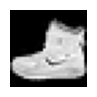

In [98]:
ds = tds['train']
img = ds[0][x]
show_image(img, figsize=(1,1))

In [99]:
cf = collate_dict(ds)
cf

<function miniai.datasets.collate_dict.<locals>._f(b)>

In [100]:
def collate_(b):
  return to_device(cf(b))


def data_loaders(dsd, bs, **kwargs):
  return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}


In [102]:
dls = data_loaders( tds, bs, collate_fn = collate_)
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x7cfdf8e22230>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7cfdf8e222c0>}

In [103]:
dt = dls['train']
dv = dls['test']
dt,dv

(<torch.utils.data.dataloader.DataLoader at 0x7cfdf8e22230>,
 <torch.utils.data.dataloader.DataLoader at 0x7cfdf8e222c0>)

In [105]:
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [109]:
labels = ds.features['label'].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [110]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)
titles

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot')

In [111]:
# itemgetter??

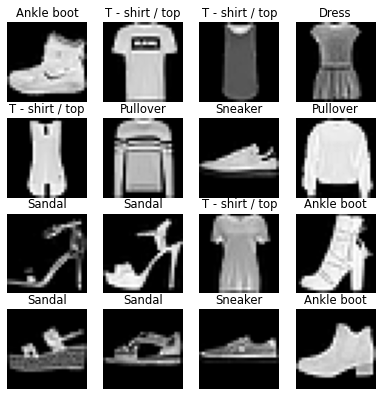

In [112]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

In [113]:
## Warmup - classify

#

In [12]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [13]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31304107, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5235060, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [14]:
dsd = load_dataset(name)
dsd # DatasetDict  -  dataset dictionary

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [15]:
train, test = dsd['train'], dsd['test']   # fetching element from DatasetDict using keys

train.shape, test.shape

((60000, 2), (10000, 2))

In [16]:
train[0], test[0]  # here we are getting dictionaries, not tuple

({'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  'label': 9})

In [17]:
x , y = 'image' ,'label' # for
x , y

('image', 'label')

In [18]:
x, y = ds_builder.info.features
x,y



('image', 'label')

In [19]:
img = train[0][x]
img

In [20]:
train[0][y]

9

In [21]:
train[:5][x], train[:5][y]

([<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 [9, 0, 0, 3, 0])

In [22]:
featy = train.features[y]  # label names
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [23]:
xb,yb = train[:5][x] , train[:5][y]
xb,yb

([<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 [9, 0, 0, 3, 0])

In [24]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [25]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [26]:
# collate function will return dictionary


def collate_fn(b):
  return {
      x:torch.stack([
          TF.to_tensor(o[x]) for o in b
      ]),

      y:tensor([o[y] for o in b])
  }

In [27]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))

b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [28]:
def transforms(b):  # we can fo collate_fn using transform
  b[x] = [TF.to_tensor(o) for o in b[x]]  # no satcking # pytorch already knows how to collate dictionaries of tenaors
  return b

In [29]:
tds = train.with_transform(transforms) # with_transform expects transforms to return value i.e. not an inplace function  # it `transforms` to every element
# whenever __getitem__ will be called it will call`transforms` on fly  # means its not cached
dl = DataLoader(tds, batch_size=16)  # so data loader can be created without collate function because pytorch collates dicts but default
b = next(iter(dl))
b[x].shape, b[y]  # x - img, y - label


(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [30]:
def _transformi(b):
  b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
"""
this inplace function does not return results but `with_transform` need `transforms` to return data
"""

'\nthis inplace function does not return results but `with_transform` need `transforms` to return data\n'

In [31]:
def inplace(f):
  def _f(b):
    f(b)
    return b
  return _f

In [32]:
transformi = inplace(_transformi)

In [33]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [34]:
@inplace
def transformi(b):
  b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [35]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [36]:
d= dict(
    a=1,
    b=2,
    c=3
)

In [37]:
ig = itemgetter('a','c')
ig(d)

(1, 3)

In [38]:
class D:
  def __getitem__(self, k):
    return 1 if k=='a' else 2 if k=='b' else 3

In [39]:
d=D()
ig(d)

(1, 3)

In [40]:
list(tdsf.features)

['image', 'label']

In [41]:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4])
default_collate(batch) # default_collate takes the matching keys and collate the values

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [42]:
#|export


# we will be using this function too much

def collate_dict(ds):  # converting dict into tuple

  get = itemgetter(*ds.features)
  def _f(b): return (get(default_collate(b)))
  # breakpoint()

  return _f

In [43]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,yb = next(iter(dlf))
xb.shape,  yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

# Plotting images

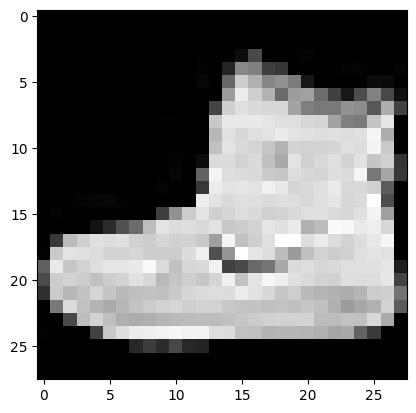

In [44]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0])

In [45]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)  # making sure its in correct Axes order
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)   # As we are passing kwargs to ax.imshow(), fc.delegates adds parameters related to that too
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax

In [46]:
help(show_image) # all extra parameters are coming for @fc.delegates

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



<Axes: >

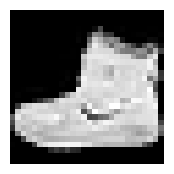

In [47]:
show_image(img, figsize=(2,2))

<Axes: >

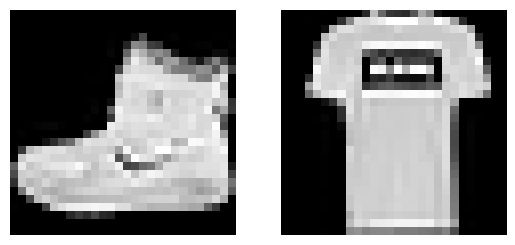

In [48]:
# making subplots
fig, axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1])

In [49]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [50]:
from nbdev.showdoc import show_doc


In [51]:
show_doc(subplots)


---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

In [52]:
show_doc(collate_dict) # make docuentatio coming from comments

---

### collate_dict

>      collate_dict (ds)

|    | **Details** |
| -- | ----------- |
| ds | converting dict into tuple |

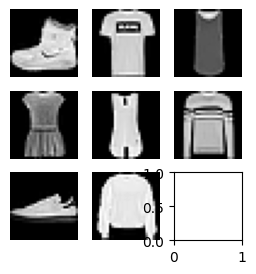

In [53]:
fig, axs = subplots(3,3, imsize=1)
imgs  = xb[:8]
for ax, img in zip(axs.flat, imgs):
  show_image(img, ax)

In [54]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

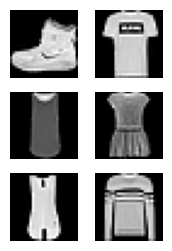

In [55]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [56]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [57]:
yb = b['label']
lbls = yb[:8]


In [58]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

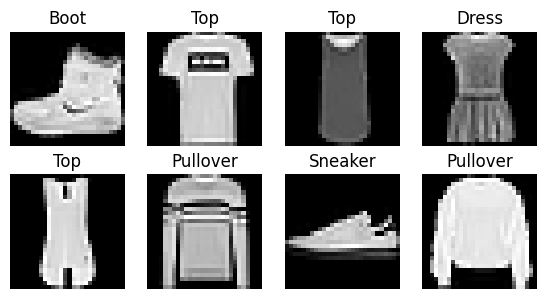

In [59]:
show_images(imgs, imsize=1.7, titles=titles)


In [60]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

# Export

In [61]:
# import nbdev; nbdev.nbdev_export()